## General Introduction of Time Series Analysis
This notebook introduces several commonly used time series analysis techniques
* [ARIMA](#ARIMA)
* [Prophet](#Prophet)
* [NeuronProphet](#NeuronProphet)
* [LSTM](#LSTM)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [4]:
from numpy.random import seed
seed(2)
import torch

In [5]:
## import data
tunnel = pd.read_csv("../data/tunnel.csv", parse_dates=["Day"])
n_future = 7

In [6]:
tunnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day          747 non-null    datetime64[ns]
 1   NumVehicles  747 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.8 KB


<Axes: >

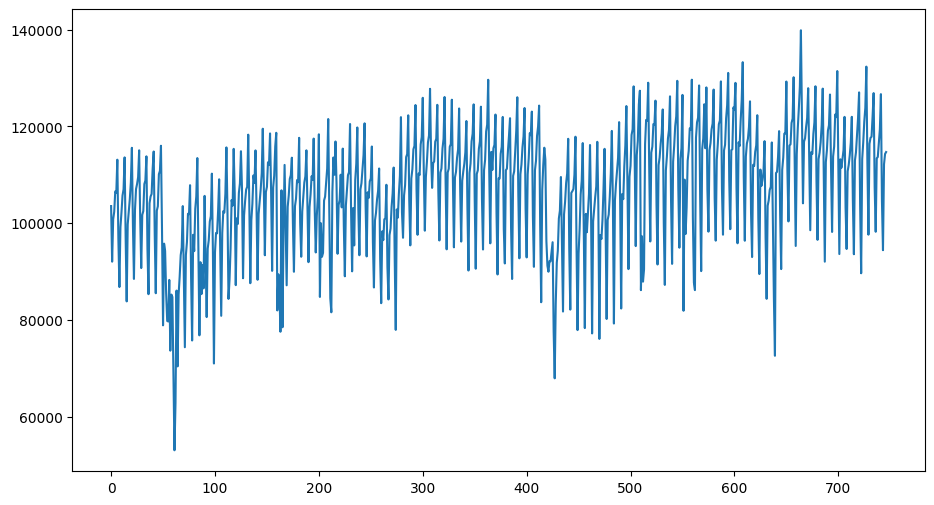

In [7]:
tunnel['NumVehicles'].plot(figsize=(11, 6))

In [8]:
# separate data into training and test 
# the training data contains all data before the last 7 days
# the test data contains the last 7 days data. set n_future = 7

# set_index to set Day column as index column and returns
# the value of NumVehicles column as a numpy array

n_future = 7
size = tunnel.shape[0] - n_future
data = tunnel.set_index("Day")

train = data[:size].values
test = data[size:].values

print(f"type of train, {type(train)}")


type of train, <class 'numpy.ndarray'>


### ARIMA

In [9]:
# build the d=1 part to perform the first order differentiate between each neighboring elements
data_len = len(tunnel['NumVehicles'])

z = np.arange(data_len - 1)
for i in range(1, data_len):
    z[i-1] = data.values[i] - data.values[i-1]   

C:\Users\huang\AppData\Local\Temp\ipykernel_23292\3902465181.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i-1] = data.values[i] - data.values[i-1]


In [11]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/9.9 MB 6.1 MB/s eta 0:00:02
   ----------------- ---------------------- 4.2/9.9 MB 10.5 MB/s eta 0:00:01
   ------------------------- -------------- 6.3/9.9 MB 11.7 MB/s eta 0:00:01
   ------------------------------------- -- 9.2/9.9 MB 11.0 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 10.6 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [s

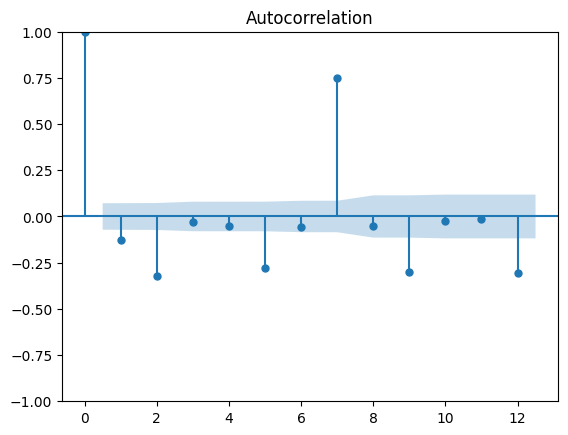

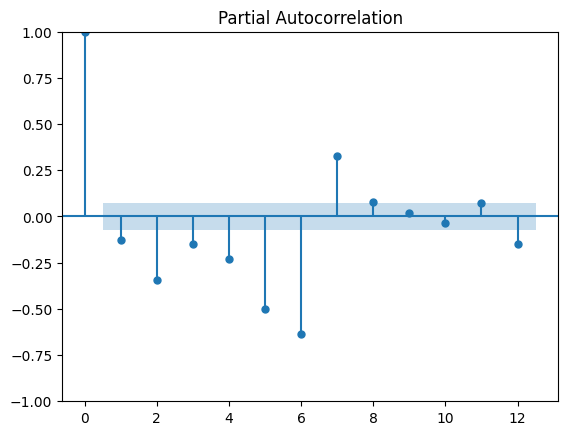

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# acf is used to find q and pacf is used to find p
# here we use p = 7 and q = 2
_ = plot_acf(z, lags = 12)
_ = plot_pacf(z, lags = 12)

In [236]:
# use ARIMA model to predict the data. Both the input and output
# are numpy array, or array like data structure

# build input data as a list since we will continuously add
# data points from test to the history for prediction

from sklearn.metrics import mean_squared_error
history = [x for x in train]
predictions = []

for i in range(n_future):
    model = ARIMA(history, order=(7, 1, 2))
    model_fit = model.fit()
    y_hat = model_fit.forecast()[0]
    predictions.append(y_hat)
    history.append(test[i])
mse = mean_squared_error(test, predictions) 
rms = np.sqrt(mse)

print(rms)


4030.643664096965


Text(0, 0.5, 'rms')

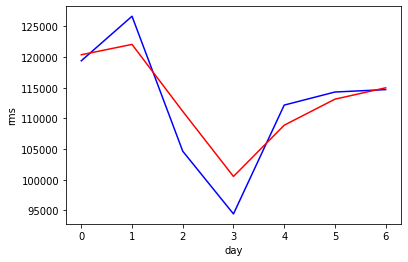

In [237]:
plt.plot(test, color="blue", label="test")
plt.plot(predictions, color="red", label="predict")
plt.xlabel("day")
plt.ylabel("rms")

### Prophet
* Prophet only accepts the column names of ds and y where ds is the time axis and y is the value to predict
* we first reset index using inplace = True to reset Day column back and then rename the Day column to ds and NumVehicles as y
* initialize a model by Prophet, and then fit and predict the value


In [238]:
data.reset_index(inplace = True)

In [239]:
data = data.rename(columns = {"Day": "ds", "NumVehicles": "y"})
df_train, df_predict = data[:size], data.iloc[size:, 0].to_frame()

In [240]:
from prophet import Prophet
model = Prophet()
model_fit = model.fit(df_train)
pred = model.predict(df_predict)

14:55:12 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing


In [241]:
error = mean_squared_error(data.iloc[size:, 1].values, pred.yhat)
rms = np.sqrt(error)
print(rms)

2398.532508622324


Text(0, 0.5, 'values')

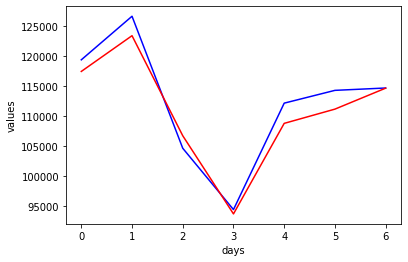

In [242]:
plt.plot(data.iloc[size:, 1].values, color="blue", label="test")
plt.plot(pred.yhat, color="red", label="pred")
plt.xlabel("days")
plt.ylabel("values")

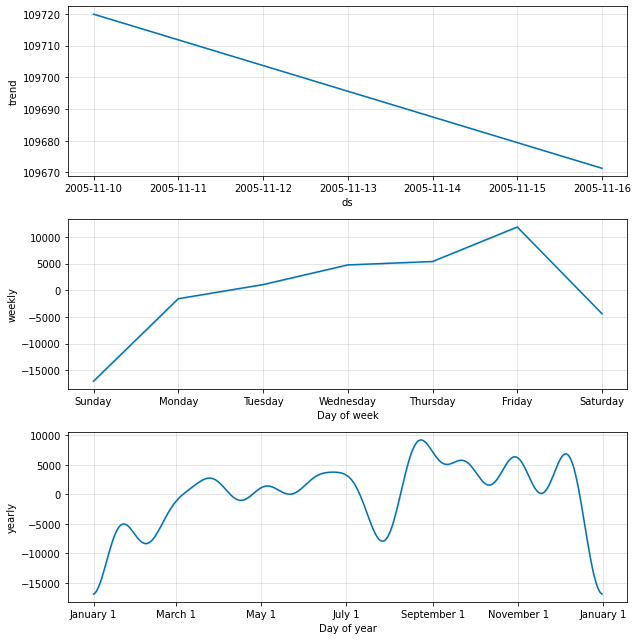

In [243]:
_ = model.plot_components(pred)

### NeuronProphet
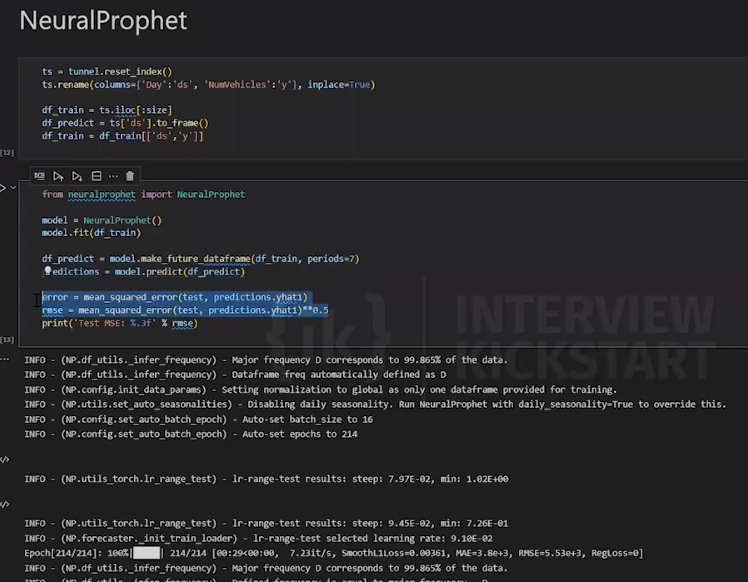
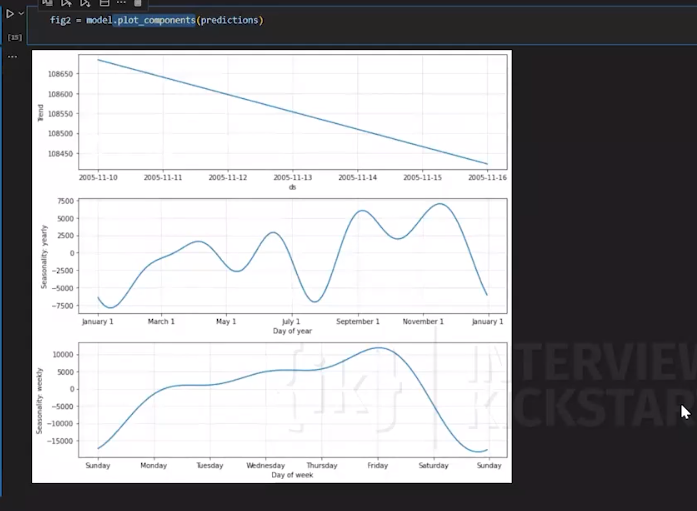

### LSTM
* implementation of Pytorch
* define LSTM layer 
* initialize a simple two stacked LSTM layers with a final `y_pred` layer using regression mse as the loss funtion

In [244]:
from sklearn.preprocessing import StandardScaler
tunnel = tunnel.set_index("Day").to_period()
df_for_training = tunnel[['NumVehicles']].astype(float)
scaler = StandardScaler()
scaler = scaler.fit(tunnel)
df_for_training_scaled = scaler.transform(tunnel)

In [245]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)

for i in range(n_past, len(df_for_training_scaled) - n_future+1):
    trainX.append(df_for_training_scaled[i - n_past:i])
    trainY.append(df_for_training_scaled[i:i + n_future])
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (727, 14, 1).
trainY shape == (727, 7, 1).


In [246]:
# trainX = np.squeeze(trainX, axis=2)
# trainY = np.squeeze(trainY, axis = 2)
# print(f"trainX shape {trainX.shape}")
# print(f"trainY shape {trainY.shape}")

In [275]:
import torch
import torch.nn as nn

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(CustomLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, 1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, 1, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.linear = nn.Linear(hidden_size2, trainY.shape[1])

    def forward(self, x):
        # Pass through the first LSTM layer (returning the full sequence)
        out, _ = self.lstm1(x)
        
        # Pass through the second LSTM layer
        out, _ = self.lstm2(out)
        out = self.dropout(out)

        # Apply the final linear layer
        out = self.linear(out[:, -1, :])  # Take the last time step output

        return out

# Example usage:
input_size = 10  # Number of features in input data
hidden_size1 = 10  # Hidden units in the first LSTM layer
hidden_size2 = 5  # Hidden units in the second LSTM layer


# Create an instance of CustomLSTM
model = CustomLSTM(input_size, hidden_size1, hidden_size2)
inputs_tensor = torch.tensor(trainX, dtype=torch.float32)
outputs = model(inputs_tensor)

print("Output shape:", outputs.shape)


Output shape: torch.Size([727, 7])


In [276]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


# Example custom dataset
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx].squeeze()}
        return sample


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create a custom dataset
tensorX = torch.tensor(trainX, dtype=torch.float32)
tensorY = torch.tensor(trainY, dtype=torch.float32)
my_dataset = MyDataset(tensorX, tensorY)

# Create a DataLoader
batch_size = 14
my_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=False)


# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    for batch in my_dataloader:
        inputs, targets = batch['data'], batch['label']
        optimizer.zero_grad()
        outputs = model(inputs)        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"======================Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")    
    # Example usage


======================Epoch [1/200], Loss: 0.9889010190963745
======================Epoch [2/200], Loss: 0.9365411996841431
======================Epoch [3/200], Loss: 0.859458327293396
======================Epoch [4/200], Loss: 0.773270845413208
======================Epoch [5/200], Loss: 0.6829498410224915
======================Epoch [6/200], Loss: 0.617190957069397
======================Epoch [7/200], Loss: 0.6448058485984802
======================Epoch [8/200], Loss: 0.7487941384315491
======================Epoch [9/200], Loss: 0.6505876183509827
======================Epoch [10/200], Loss: 0.5590987801551819
======================Epoch [11/200], Loss: 0.5159537196159363
======================Epoch [12/200], Loss: 0.6018570065498352
======================Epoch [13/200], Loss: 0.559619128704071
======================Epoch [14/200], Loss: 0.5658926367759705
======================Epoch [15/200], Loss: 0.5037556886672974
======================Epoch [16/200], Loss: 0.4508894085884094
=====

======================Epoch [130/200], Loss: 0.22837598621845245
======================Epoch [131/200], Loss: 0.3278364837169647
======================Epoch [132/200], Loss: 0.2822723090648651
======================Epoch [133/200], Loss: 0.2704046964645386
======================Epoch [134/200], Loss: 0.2311844825744629
======================Epoch [135/200], Loss: 0.19987395405769348
======================Epoch [136/200], Loss: 0.22706927359104156
======================Epoch [137/200], Loss: 0.22254711389541626
======================Epoch [138/200], Loss: 0.23116101324558258
======================Epoch [139/200], Loss: 0.251284122467041
======================Epoch [140/200], Loss: 0.32682690024375916
======================Epoch [141/200], Loss: 0.28058287501335144
======================Epoch [142/200], Loss: 0.27241620421409607
======================Epoch [143/200], Loss: 0.21630489826202393
======================Epoch [144/200], Loss: 0.26021361351013184
======================Epoch [14

In [277]:
with torch.no_grad():
    prediction = model(tensorX).detach().numpy()
y_pred_future = scaler.inverse_transform(prediction)[-1]

p1 = model(tensorX).detach().numpy()
p1 = scaler.inverse_transform(p1)[-1]
error = mean_squared_error(test,y_pred_future)
rmse = mean_squared_error(test, y_pred_future)**0.5
print('Test MSE: %.3f' % rmse)

Test MSE: 2900.332


In [278]:
y_pred_future

array([120603.25 , 124018.2  , 108521.836,  96556.24 , 107129.86 ,
       116228.734, 113341.38 ], dtype=float32)

In [279]:
test

array([[119386],
       [126650],
       [104646],
       [ 94424],
       [112165],
       [114296],
       [114690]], dtype=int64)